# Lựa chọn đường MA (Moving Average) tốt nhất cho một cổ phiếu
#### Ý tưởng & Quy trình thực hiện: 
* Dùng tập dữ liệu export trên V-pro, lấy 3 năm gần nhất để tính toán (ai thích có thể dùng nhiều data hơn). (ai thích export thử data từ Vpro có thể mở tài khoản ủng hộ mình tại đây https://www.cafechungkhoan.com/p/dich-vu.html)
* Chia tập dữ liệu này làm 2 tệp khác nhau, 60% lượng dữ liệu dùng để đào tạo, 40% lượng dữ liệu dùng để kiểm tra
* Chạy vòng lặp các đường MA khác nhau (trong bài viết là từ 5 ngày đến 200 ngày). Sau đó, tính mean của lợi nhuận sau N ngày khi giá đóng cửa vượt MA (trong bài viết mình dùng 40 phiên là tầm 2 tháng)
* Sử dụng trung bình di chuyển này để tính lợi nhuận trung bình trên tập kiểm tra (bài viết sau sẽ dùng phương pháp Cross Validation để kiểm định tốt hơn)
* Xác minh rằng lợi nhuận trung bình trên tập kiểm tra tương tự như thống kê với lợi nhuận trung bình đạt được trên tập đào tạo

#### Khuyến cáo:
Đây chỉ là bài viết mang tính học thuật chứ nhà đầu tư "dài hạn" (nhưng T3 thì bán=)) như mình thì ko chỉ dùng MA để đầu tư, mà còn đọc kĩ những vấn đề nội tại của doanh nghiệp nữa. Hi vọng các bác phản biện mang tính xây dựng, nói vậy chứ góp ý gì cũng nhận cả. Với lại, về phương pháp phân tích kỹ thuật, các bác ưu dùng các loại ichimoku, chỉ số tự build,... Nhưng riêng em theo trường phái price action, chủ yếu dùng candle stick và MA. Do đó phương pháp trình bày trong bài viết đã đủ để em dùng rồi :))

#### Những ý tưởng khác:
Sắp tới mình sẽ thử viết các ý tưởng về: phân bổ tỉ trọng lợi nhuận để đạt tối đa tỉ số return/risk (Efficient Frontier), thử dùng python để tìm 2 đường MA hiệu quả trong chiến lược crossover trading,...

---------------------------
#### Lê Đặng Trung Hiếu
*Phòng ABS, CTCP Chứng khoán Bản Việt(VCI), cafechungkhoan.com*

#### Nếu bạn chưa biết: Trung bình động là gì?

Trung bình động (Moving Average) là một chỉ báo thể hiện giá trị trung bình của giá chứng khoán trong một khoảng thời gian. Khi giá chứng khoán thay đổi thì giá trung bình cũng thay đổi theo. Đường trung bình đơn giản (SMA) được tính bằng cách lấy tổng mức giá trung bình (A) rồi chia cho tổng số phiên (n) (Trong bài viết của mình là nói tới SMA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime

Tiền xử lí dữ liệu cũng hơi lằng nhằng, khi các bạn làm thử giữa biểu diễn time series và biểu diễn MA sẽ thấy rõ hơn. Mình pass qua tiền xử lí dữ liệu mà đi thẳng vào vấn đề. Ở đây mình dùng cổ phiếu HPG làm mẫu, các mã khác làm tương tự.

In [2]:
eda = pd.read_excel(r"C:\PYTHON LEARNING\DATA\HPG MA.xls")
eda = pd.DataFrame(eda)
eda = eda.reset_index()
eda = eda.sort_values(by='index', ascending = False)
eda['Date'] = pd.to_datetime(eda['Date'])
eda

*** No CODEPAGE record, no encoding_override: will use 'ascii'


,index,Date,Time,Close
799,799,2017-04-17,09:00:00,15800
798,798,2017-04-18,09:00:00,15700
797,797,2017-04-19,09:00:00,16000
796,796,2017-04-20,09:00:00,15750
795,795,2017-04-21,09:00:00,15750
...,...,...,...,...
4,4,2020-06-22,09:00:00,27300
3,3,2020-06-23,09:00:00,27000
2,2,2020-06-24,09:00:00,27000
1,1,2020-06-25,09:00:00,27300


Tạo dataframe chỉ có Date và Close, set index cho 'Date'

In [3]:
data = []
data = pd.DataFrame(data)
data['Date'] = eda['Date']
data['Close'] = eda['Close']
data = data.dropna()
data = data.set_index('Date')
data

,Close
Date,
2017-04-17,15800
2017-04-18,15700
2017-04-19,16000
2017-04-20,15750
2017-04-21,15750
...,...
2020-06-22,27300
2020-06-23,27000
2020-06-24,27000


### Trực quan 3 đường MA phổ biến được dùng là 20, 50 và 200 phiên
Trực quan 3 đường MA phổ biến được dùng là 20, 50 và 200, sau đó quan sát MA tốt nhất được tính toán cuối bài để đánh giá về hiệu quả

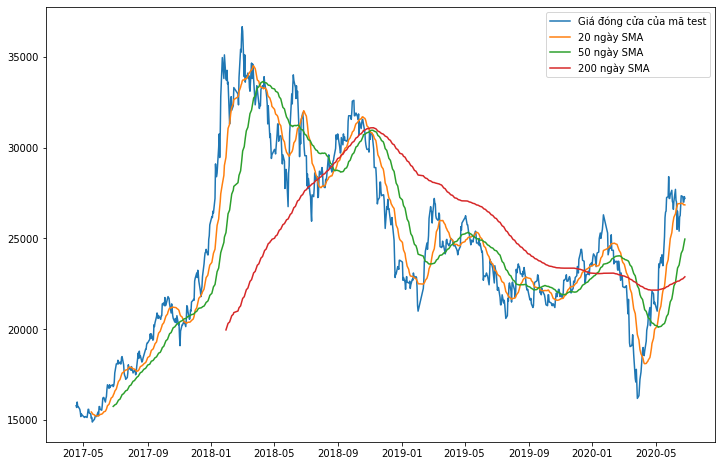

In [4]:
plt.figure(figsize = (12,8))
plt.plot(data['Close'],label='Giá đóng cửa của mã test')
plt.plot(data['Close'].rolling(20).mean(),label = "20 ngày SMA")
plt.plot(data['Close'].rolling(50).mean(),label = "50 ngày SMA")
plt.plot(data['Close'].rolling(200).mean(),label = "200 ngày SMA")
plt.legend()
plt.show()

In [5]:
so_phien_giu_lai = 40
data['Forward Close'] = data['Close'].shift(-so_phien_giu_lai)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [6]:
result = []
train_size = 0.6

for sma_length in range(5,200):
    data['SMA'] = data['Close'].rolling(sma_length).mean()
    data['input'] = [int(x) for x in data['Close'] > data['SMA']]
    df = data.dropna()
    training = df.head(int(train_size * df.shape[0]))
    test = df.tail(int((1 - train_size) * df.shape[0]))
    tr_returns = training[training['input'] == 1]['Forward Return']
    test_returns = test[test['input'] == 1]['Forward Return']
    mean_forward_return_training = tr_returns.mean()
    mean_forward_return_test = test_returns.mean()
    pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
    result.append({'sma_length':sma_length,'training_forward_return': mean_forward_return_training,'test_forward_return': mean_forward_return_test})

In [7]:
result.sort(key = lambda x : -x['training_forward_return'])
print(result[0])

{'sma_length': 17, 'training_forward_return': 0.08672504372674221, 'test_forward_return': 0.005130096309641967}


In [8]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

### Trực quan dữ liệu tính toán với Best MA của HPG là 17

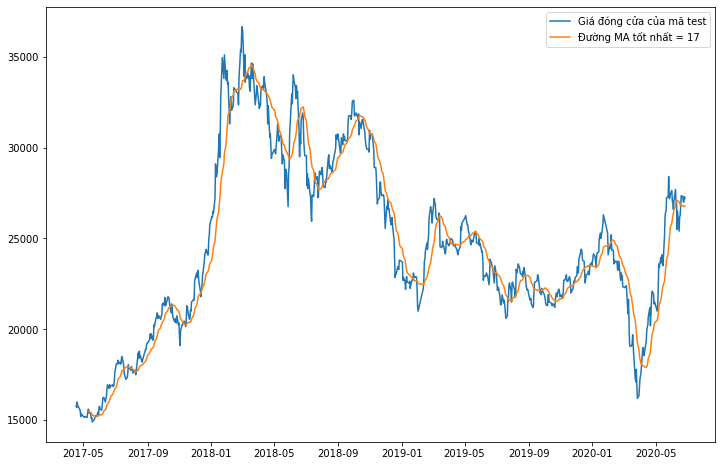

In [9]:
plt.figure(figsize = (12,8))
plt.plot(data['Close'],label='Giá đóng cửa của mã test')
plt.plot(data['SMA'],label = "Đường MA tốt nhất = {}".format(best_sma))
plt.legend()
plt.show()

## Lời kết

Trong bài viết này, trình bày một thuật toán đơn giản để tìm Trung bình động tốt nhất cho một mã giao dịch nào đó. Đây chỉ là tiền đề áp dụng auto trong đầu tư, có thể dễ dàng được áp dụng mỗi ngày. 
Theo cách này, một nhà giao dịch có thể dễ dàng thích ứng với những thay đổi của thị trường và biến động giá.